## Produce table with all collected metrics for all available configurations

In [1]:
import pandas as pd
import os
import cPickle as pickle
import matplotlib.pylab as plt
from collections import defaultdict
import re
import numpy as np
from thesis.utils.metrics import *

In [2]:
#ROOT_RESULTS_LOCATION = '/big/s/shalaby/parameter_search_doc2vec_models_new/sample_0.01/'
ROOT_RESULTS_LOCATION = '/big/s/shalaby/parameter_search_doc2vec_models_new/full/'
CLASSIFICATION_TYPE = 'sections'
METRICS_PNG_FILE = '{}_validation_metrics.png'
METRICS_PKL_FILE = '{}_validation_metrics.pkl'
DOC2VEC_FILES_PREFIX = 'model'
WORD2VEC_METRICS_FILE = 'word2vec_metrics.pkl'
EPOCH_PREFIX = 'epoch_{}'

DOC2VEC_MAX_EPOCHS = 20

CLASSIFICATION_SEPARATOR = ' ** '

CLASSIFICATION_TYPES_TO_USE = ['sections']
METRICS_TO_USE = ['coverage_error', 'f1_micro', 'f1_macro']
METRICS_BEST_VALUE_FUNC = {'coverage_error': np.min, 'f1_micro': np.max, 'f1_macro': np.max}
METRICS_BEST_INDEX_FUNC = {'coverage_error': np.argmin, 'f1_micro': np.argmax, 'f1_macro': np.argmax}

In [3]:
def get_subdirectories(d):
    #return filter(os.path.isdir, [f for f in os.listdir(d)])
    return [f for f in os.listdir(d) if os.path.isdir(os.path.join(d,f))]
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [4]:
get_subdirectories(ROOT_RESULTS_LOCATION)

['doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'vocab_model',
 'doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None']

In [5]:
os.listdir(ROOT_RESULTS_LOCATION)

['doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'vocab_model',
 'doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None']

In [6]:
table_rows = []
table_index = []
for doc2vec_method in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):
    print doc2vec_method
    epochs_path = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_method)
    # this will have the structure dict of classifiers -> dict of metrics -> list of values throughout the epoch
    epoch_metrics = dict()
    epoch_word2vec_results = []
    epochs_trained = 0
    for epoch in natural_sort(get_subdirectories(epochs_path)):
        print epoch
        epochs_trained += 1
        epoch_path =  os.path.join(epochs_path, epoch)
        if os.path.exists(os.path.join(epoch_path, WORD2VEC_METRICS_FILE)):
            method_word2vec_results = pickle.load(open(os.path.join(epoch_path, WORD2VEC_METRICS_FILE), 'r'))
            epoch_word2vec_results.append(method_word2vec_results)
        for classifier in get_subdirectories(epoch_path):
            # the values of a metric for a specific classifier throughout the epochs
            if not epoch_metrics.get(classifier): epoch_metrics[classifier] = defaultdict(list)
            
            for classf_type in CLASSIFICATION_TYPES_TO_USE:
                classifier_metrics_file = os.path.join(epoch_path, classifier, METRICS_PKL_FILE.format(classf_type))
                if os.path.exists(classifier_metrics_file):
                    classifier_metrics = pickle.load(open(classifier_metrics_file, 'r'))
                    # due to a mistake we made, some metrics files contain the whole history of metrics throughout the epochs
                    # print classifier_metrics
                    if type(classifier_metrics) is list:
                        classifier_metrics = classifier_metrics[-1]
                        pickle.dump(classifier_metrics, open(classifier_metrics_file, 'w'))
                    for metric_name in METRICS_TO_USE:
                        metric_full_name = classf_type + CLASSIFICATION_SEPARATOR + metric_name
                        epoch_metrics[classifier][metric_full_name].append(classifier_metrics[metric_name])
                        
    
    total = 0
    word2vec_epoch_correct_results = []
    for res in epoch_word2vec_results:
        total_result = [d for d in res if d['section'] == 'total'][0]
        total_correct = len(total_result['correct'])
        total_incorrect = len(total_result['incorrect'])
        if total == 0: total = total_correct + total_incorrect
        word2vec_epoch_correct_results.append(total_correct)
    best_word2vec_value = np.max(word2vec_epoch_correct_results) if len(word2vec_epoch_correct_results) else np.NaN
    best_word2vec_epoch = np.argmax(word2vec_epoch_correct_results) if len(word2vec_epoch_correct_results) else np.NaN
        
    # now that we are done with our epochs, lets figure out which epoch had the best value of every metric
    for classifier_name in sorted(epoch_metrics.keys()):
        classifier_metrics_dict = defaultdict(float)
        for metric_name in epoch_metrics[classifier_name].keys():
#             best_epoch = np.argmax(epoch_metrics[classifier_name][metric_name])
#             best_value = np.max(epoch_metrics[classifier_name][metric_name])
            just_metric = metric_name.split(CLASSIFICATION_SEPARATOR)[1]
            best_epoch = METRICS_BEST_INDEX_FUNC[just_metric](epoch_metrics[classifier_name][metric_name])
            best_value = METRICS_BEST_VALUE_FUNC[just_metric](epoch_metrics[classifier_name][metric_name])
            metric_range = abs(np.max(epoch_metrics[classifier_name][metric_name]) - np.min(epoch_metrics[classifier_name][metric_name]))
            classifier_metrics_dict[metric_name] = round(best_value, 3)
            classifier_metrics_dict[metric_name + ' -> epoch'] = best_epoch + 1
            classifier_metrics_dict[metric_name + ' range'] = round(metric_range, 3)

        classifier_metrics_dict['word2vec result'] = best_word2vec_value
        classifier_metrics_dict['word2vec result epoch'] = best_word2vec_epoch
        classifier_metrics_dict['Epochs'] = epochs_trained

        table_rows.append(classifier_metrics_dict)
        table_index.append(doc2vec_method + ' / ' + classifier_name)
        
            
df = pd.DataFrame(data=table_rows, index=table_index)            
df

doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_6
epoch_7
epoch_8
epoch_9
epoch_10
epoch_11
epoch_12
epoch_13
epoch_14
epoch_15
epoch_16
epoch_17
epoch_18
epoch_19
doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
epoch_6
epoch_7
epoch_8
doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
epoch_6
epoch_7
epoch_8
doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
epoch_6
epoch_7
epoch_8
doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None
epoch_1
epoch_2
epoch_3
epoch_4
epoch_5
vocab_model


,Epochs,sections ** coverage_error,sections ** coverage_error -> epoch,sections ** coverage_error range,sections ** f1_macro,sections ** f1_macro -> epoch,sections ** f1_macro range,sections ** f1_micro,sections ** f1_micro -> epoch,sections ** f1_micro range,word2vec result,word2vec result epoch
doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_1_reg_0.01_classweights_balanced,14,2.998,14,0.625,0.518,14,0.085,0.612,14,0.100,2850,10
doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,8,3.153,7,0.319,0.496,7,0.017,0.590,7,0.017,0,0
doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_1_reg_0.01_classweights_balanced,8,3.029,5,0.495,0.507,6,0.058,0.597,6,0.072,3165,1
doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,8,3.120,7,0.338,0.497,7,0.037,0.591,4,0.037,0,0
doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,5,2.983,5,0.582,0.514,5,0.066,0.603,5,0.087,3065,1


In [8]:
df.sort_values(by='sections ** coverage_error', ascending=True)

,Epochs,sections ** coverage_error,sections ** coverage_error -> epoch,sections ** coverage_error range,sections ** f1_macro,sections ** f1_macro -> epoch,sections ** f1_macro range,sections ** f1_micro,sections ** f1_micro -> epoch,sections ** f1_micro range,word2vec result,word2vec result epoch
doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,20,3.197,15,0.221,0.548,14,0.038,0.635,14,0.049,2413,9
doc2vec_size_500_w_5_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_10_reg_0.01_classweights_balanced,9,3.264,5,0.088,0.531,7,0.006,0.618,7,0.006,0,0
doc2vec_size_1000_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,13,3.268,6,0.105,0.541,12,0.018,0.630,12,0.018,0,0
doc2vec_size_300_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,20,3.273,13,0.138,0.542,17,0.019,0.631,17,0.027,0,0
doc2vec_size_100_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,20,3.274,20,0.165,0.534,20,0.021,0.621,20,0.028,0,0
doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,20,3.281,19,0.094,0.541,20,0.020,0.628,20,0.023,0,0
doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,20,3.286,20,0.107,0.539,20,0.019,0.625,20,0.023,0,0
doc2vec_size_300_w_5_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_1000_reg_0.01_classweights_balanced,20,3.294,17,0.072,0.536,17,0.013,0.623,17,0.015,0,0
doc2vec_size_200_w_12_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.01_classweights_balanced,13,3.302,8,0.102,0.530,12,0.010,0.616,1,0.012,0,0
doc2vec_size_300_w_5_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None / svm_iter_100_reg_0.001_classweights_balanced,20,3.307,14,0.121,0.537,20,0.018,0.625,19,0.018,0,0


In [65]:
[d['section'] for d in method_word2vec_results]

[u'capital-common-countries',
 u'capital-world',
 u'currency',
 u'city-in-state',
 u'family',
 u'gram1-adjective-to-adverb',
 u'gram2-opposite',
 u'gram3-comparative',
 u'gram4-superlative',
 u'gram5-present-participle',
 u'gram6-nationality-adjective',
 u'gram7-past-tense',
 u'gram8-plural',
 u'gram9-plural-verbs',
 'total']

In [13]:
pd.DataFrame([{'dd':2,'ee':3,'ff':4},{'dd':2,'ee':3}], index=['sdfsf','sdlfsdfsdf'])

,dd,ee,ff
sdfsf,2,3,4.0
sdlfsdfsdf,2,3,NaN


In [14]:
#direc_prefix = '/big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_12_type_dm_concat_1_mean_0_trainwords_1_hs_0_neg_10_vocabsize_None_curriter_{}'
#direc_prefix = '/big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'
direc_prefix = '/big/s/shalaby/parameter_search_doc2vec_models/sample_0.0001/doc2vec_size_3000_w_8_type_dm_concat_0_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None_curriter_{}'
import shutil
#to_delete = [8,9,10,11]
to_delete = range(15,30)

for i in to_delete:
    direc = direc_prefix.format(i)
    if os.path.exists(direc):
        model_folder_path = os.path.join(direc, "model")
        if os.path.exists(os.path.join(direc, "model.syn0.npy")):
            print "deleting {}".format(i)
            os.remove(model_folder_path)
            #os.remove(os.path.join(direc, "model.docvecs.doctag_syn0.npy"))
            os.remove(os.path.join(direc, "model.syn0.npy"))
            os.remove(os.path.join(direc, "model.syn1neg.npy"))

## Show Graph for specific configuration

In [28]:
natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION))

['doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_200_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_500_w_8_type_pv-dbow_concat_1_mean_0_trainwords_0_hs_0_neg_10_vocabsize_None',
 'doc2vec_size_1000_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None',
 'vocab_model']

Classifier Names

In [ ]:
classifier_names = set()
for doc2vec_method in natural_sort(get_subdirectories(ROOT_RESULTS_LOCATION)):
    epochs_path = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_method)
    for epoch in natural_sort(get_subdirectories(epochs_path)):
        epoch_path =  os.path.join(epochs_path, epoch)
        for subdirectory in natural_sort(get_subdirectories(epoch_path)):
            if not subdirectory.startswith(EPOCH_PREFIX):
                classifier_names.add(subdirectory)
natural_sort(classifier_names)

<IPython.core.display.Javascript object>


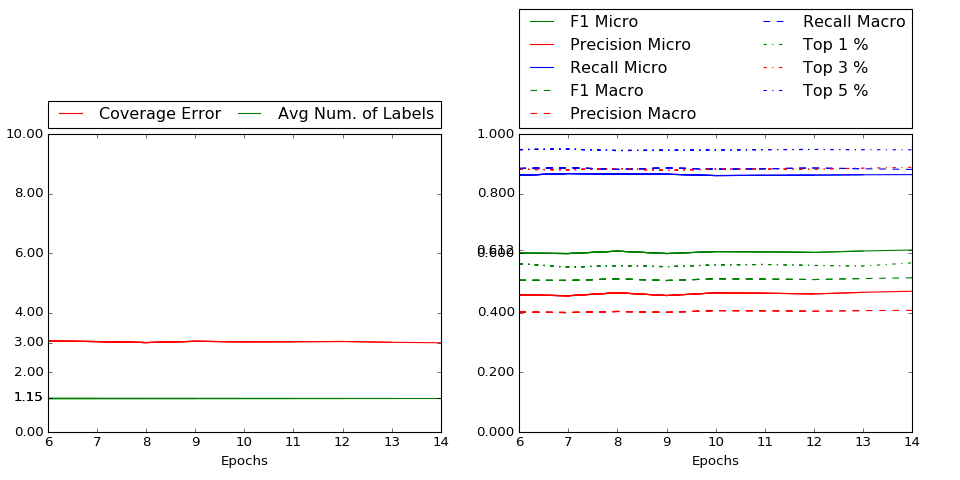

sdfsdfsf
/big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_6/svm_iter_1_reg_0.01_classweights_balanced
Epoch 06: Coverage Error -> 3.05


/home/s/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=6, right=6
  'left=%s, right=%s') % (left, right))


/big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_7/svm_iter_1_reg_0.01_classweights_balanced
Epoch 07: Coverage Error -> 3.04
/big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/svm_iter_1_reg_0.01_classweights_balanced
Epoch 08: Coverage Error -> 3.01
/big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_9/svm_iter_1_reg_0.01_classweights_balanced
Epoch 09: Coverage Error -> 3.05
/big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_10/svm_iter_1_reg_0.01_classweights_balanced
Epoch 10: Coverage Error -> 3.03
/big/s/shalaby/parameter_search_doc2vec_models_new/full/doc2vec_size_200_w_8_type_dm_concat_0_mean_1_tr

In [7]:
%matplotlib notebook
graph = MetricsGraph()
graph.init_graph()


doc2vec_approach = "doc2vec_size_200_w_8_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None"
classifier_approach = "svm_iter_1_reg_0.01_classweights_balanced"
classification_type = "sections"
for epoch in range(6,DOC2VEC_MAX_EPOCHS+1):
    try:
        metrics_folder = os.path.join(ROOT_RESULTS_LOCATION, doc2vec_approach, EPOCH_PREFIX.format(epoch), classifier_approach)
        print metrics_folder
        metrics = pickle.load(open(os.path.join(metrics_folder, METRICS_PKL_FILE.format(classification_type))))
        print "Epoch {:02d}: Coverage Error -> {:.2f}".format(epoch, metrics['coverage_error'])
        graph.add_metrics_to_graph(metrics, epoch)
    except IOError:
        break